## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images
The basic mathematic for camera calibration is x = PX, in which x is the pixel coordinate in image coordinate system and X is the object point in the world coordinate system, P is 3x4 matrix with rank 3, and P can be further decomposed into P = K[R|t], and K is the camera intrinsci matrix, R,t are the rotaion and translation matrix with respect to the world coordinate system because image coordinate system and world coordinate system are different. K is the camera matrix we want to find in the below calibration process. For planar patter, [Zhang's method](https://www.microsoft.com/en-us/research/publication/a-flexible-new-technique-for-camera-calibration/) is used with absolute conic to find the camera intrinsci matrix though the rotation and translation vector varied for different images. So we need to take images from different orientation but ensure the camera focus unchanged. 

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from PyQt5 import QtCore, QtGui, QtWidgets
%matplotlib inline

file = 'camera_cal/calibration*.jpg'

def calibrate(file):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(file)

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            cv2.imshow('img',img)
            cv2.waitKey(500)

    cv2.destroyAllWindows()

## camera calibration and undistortion of images
I save the camera parameter in a file for later use, so I do not need to calibrate camera each time I use it.

In [2]:
import pickle
images = glob.glob(file)
# ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
# cp = open('camera.p','wb')
# data = {}
# data['mtx'] = mtx
# data['dist'] = dist
# pickle.dump(data, cp)

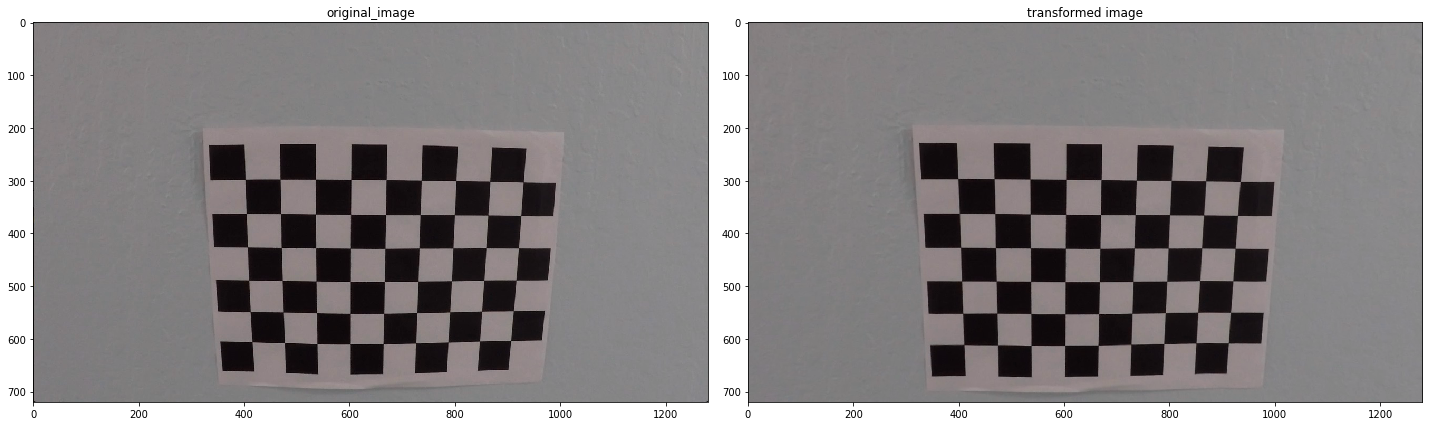

In [3]:
import random
%matplotlib inline
data = pickle.load(open('camera.p','rb'))
mtx = (data['mtx'])
dist = data['dist']
fname = random.choice(images)
image = cv2.imread(fname)
t_image = cv2.undistort(image, mtx, dist)
f,(ax1,ax2) = plt.subplots(1,2, figsize=(20,15))
ax1.imshow(image)
ax1.set_title('original_image')
ax2.imshow(t_image)
ax2.set_title('transformed image')
plt.tight_layout()

### Helper functions for perspertive transformation and calculate color, graident thresholded binary images

In [4]:
def warper(img, src, dst):
    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image
    return warped
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel = cv2.Sobel(gray,cv2.CV_64F, 1, 0)
    if orient == 'y':
        sobel = cv2.Sobel(gray,cv2.CV_64F,0,1)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize = sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize = sobel_kernel)
    sobel = np.sqrt(sobelx**2+sobely**2)
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel>=thresh[0]) & (scaled_sobel<=thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = np.absolute(cv2.Sobel(gray,cv2.CV_64F,1,0,ksize = sobel_kernel))
    sobely = np.absolute(cv2.Sobel(gray,cv2.CV_64F,0,1,ksize = sobel_kernel))
    sobel = np.arctan2(sobely, sobelx)
    binary_output = np.zeros_like(sobel)
    binary_output[(sobel>=thresh[0]) & (sobel<=thresh[1])] = 1
    return binary_output

def HLS_select(img, thresh=(0, 255), channel = 'S'):
    # 1) Convert to HLS color space
    # 2) Apply a threshold to the S channel
    # 3) Return a binary image of threshold result
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    channel = hls[:,:,2]
    if channel == 'L':
        channel = hls[:,:,1]

    binary_output = np.zeros_like(channel)
    binary_output[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    return binary_output

def RGB_select(img, thresh=(0, 255), channel = 'R'):
    channel = img[:,:,0]
    if channel == 'G':
        channel = img[:,:,1]
    elif channel == 'B':
        channel = img[:,2]
    binary_output = np.zeros_like(channel)
    binary_output[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    return binary_output

### First,  apply undistortion to the original images to remove lens radial and tangential distortion

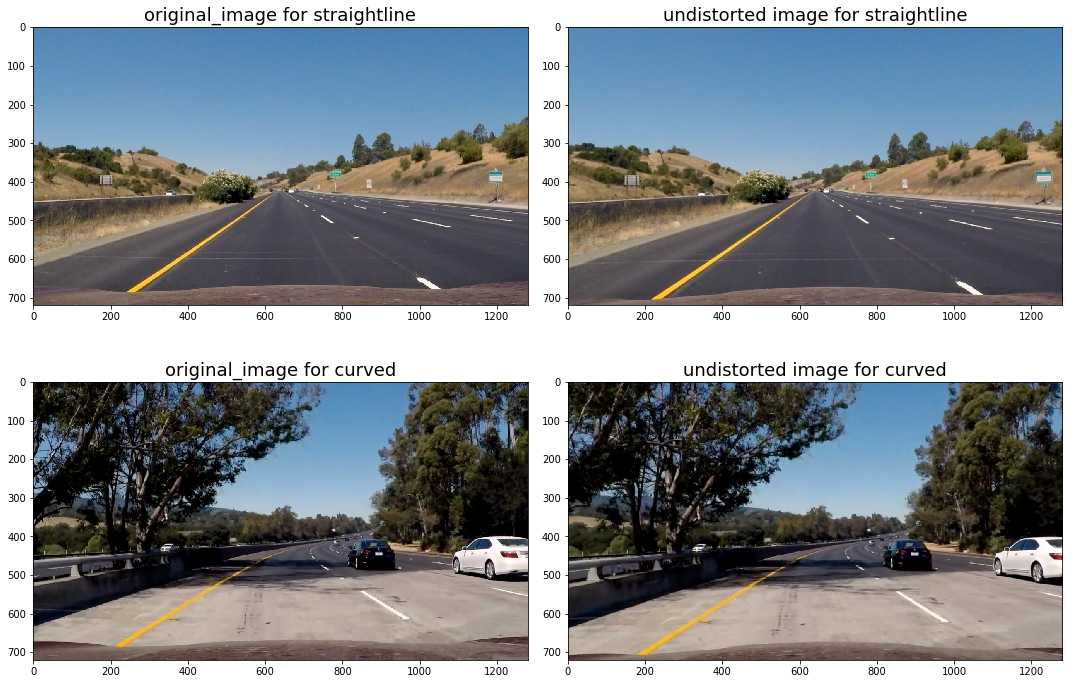

In [5]:
import matplotlib.image as mpimg
fonts = 18
image_f = 'test_images/straight_lines1.jpg'
image = mpimg.imread(image_f)
img = cv2.undistort(image, mtx, dist)
f,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(15,10))
ax1.imshow(image)
ax1.set_title('original_image for straightline',fontsize=fonts)
ax2.imshow(img)
ax2.set_title('undistorted image for straightline',fontsize=fonts)
#this is for curved image
image_f2 = 'test_images/test5.jpg'
image5_o = mpimg.imread(image_f2)
image5 = cv2.undistort(image5_o, mtx, dist)
ax3.imshow(image5_o)
ax3.set_title('original_image for curved',fontsize=fonts)
ax4.imshow(image5)
ax4.set_title('undistorted image for curved',fontsize=fonts)
plt.tight_layout()

### Second, use color transforms, gradients, etc., to create a thresholded binary image.
Here I used HLS S channel(saturation channel), RGB R channel, gradient x gradient channel, the threshold values are marked below

/Users/HJK-BD/.pyenv/versions/3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Users/HJK-BD/.pyenv/versions/3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:58: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Users/HJK-BD/.pyenv/versions/3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:60: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


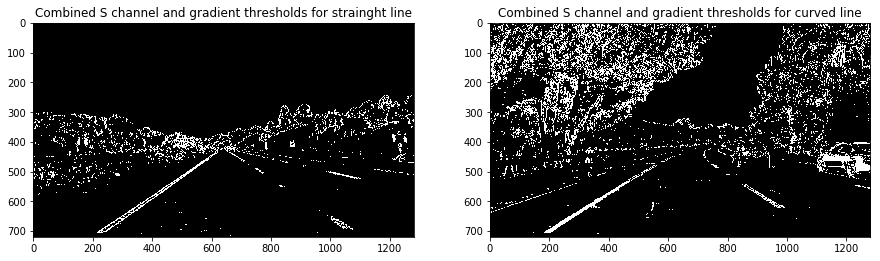

In [6]:
# Threshold color channel
def combined(img):
    s_binary = HLS_select(img, thresh=(200, 250))
    R_binary = RGB_select(img, thresh=(210, 250),channel='R')
    sgbinary = abs_sobel_thresh(img, thresh=(20,100))
    combined_binary = np.zeros_like(sgbinary)
    combined_binary[(s_binary == 1) | (sgbinary == 1) | (R_binary==1)] = 1
    return combined_binary
# Plotting thresholded images
combined_binary1= combined(img)
combined_binary2= combined(image5)
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(15,10))
ax1.set_title('Combined S channel and gradient thresholds for strainght line')
ax1.imshow(combined_binary1, cmap='gray')
ax2.set_title('Combined S channel and gradient thresholds for curved line')
ax2.imshow(combined_binary2, cmap='gray')

### Third, select a region to transform from projective space to affine space
I selected the region from the image with strainght lines. Draw the lines on both straight line images and curved line images. The next step is to test apply these transformation

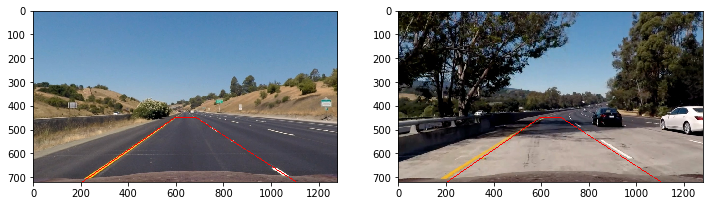

In [7]:
clone2 = img.copy()
clone3 = image5.copy()
#points = [[298,657],[1010,657],[700,460],[580,460]]
points = [[205,720],[1105,720],[685,450],[595,450]]
points = np.array(points)
points = points.reshape((-1,1,2))
cv2.polylines(clone2, [points], True,(255,0,0),thickness=2)
cv2.polylines(clone3, [points], True,(255,0,0),thickness=2)
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(12,8))
ax1.imshow(clone2)
ax2.imshow(clone3)

###Fourth, Affine transformation to have bird view
Apply a affine transformation to rectify binary image ("birds-eye view")
Here, I first tested on the strainght line to find the perspective transformation matrix, and then apply the same transformation matrix to new undistorted images.

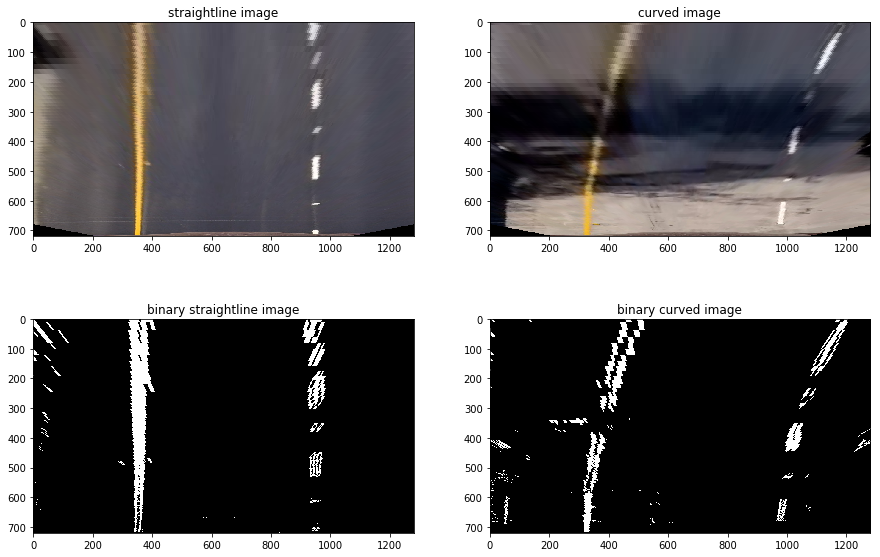

In [8]:
# src =  np.float32([[215,714],[1095,714],[656,433],[619,433]])
#src =  np.float32([[200,720],[1120,720],[720,470],[570,470]])
src = np.float32([[205,720],[1105,720],[685,450],[595,450]])
dst =  np.float32([[350,720],[950,720],[950,0],[350,0]])
Minv = cv2.getPerspectiveTransform(dst, src)
img2 = warper(img, src, dst)
image3 = warper(image5, src, dst)
com_b1 = warper(combined_binary1,src,dst)
com_b2 = warper(combined_binary2,src,dst)
f, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(15,10))
ax1.imshow(img2)
ax1.set_title('straightline image')
ax2.imshow(image3)
ax2.set_title('curved image')
ax3.imshow(com_b1,cmap='gray')
ax3.set_title('binary straightline image')
ax4.imshow(com_b2,cmap='gray')
ax4.set_title('binary curved image')

### Fifth, Check the histogram on the second curved image
Now it has three peaks due to the noises, but I can narrow the selection window to remove one outlier

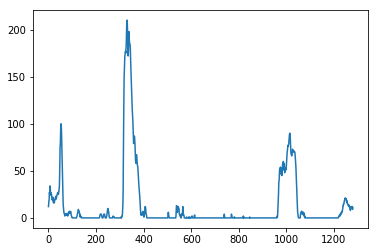

In [9]:
binary_warped = com_b2
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

### Sixth, Using sliding window method to find the lane line pixels for both left and right
I defined two methods to find the lane line pixels.The first one is with sliding window, used for the initiall blind search of the lanes, and the second is not to use sliding window, but use the fitted line from previous frames. Here I need to calculate the coefficients for line fitting equation and curvature of road
I used the code from lectures nodes.

In [10]:
def sliding_window(binary_warped,nwindows=9, visualize=False):
    
    out_image = None
    
    if visualize:
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        
    # Code from lecture notes
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[100:midpoint])
    rightx_base = np.argmax(histogram[midpoint:-100]) + midpoint
    # Choose the number of sliding windows
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        if visualize:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    fit = (left_fit, right_fit)
    
    #curvature 
    #f(y) = Ay^2 + By + C, R = (1+(2Ay+B)^2)^(3/2)/(2A)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    curvature = (left_curverad, right_curverad)
    ##finished finding curvature
    
    f = None
    if visualize:
        # Generate x and y values for plotting
#         left_fit,right_fit = sliding_window(binary_warped,nwindows=9)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        f,ax = plt.subplots(1,1)
        ax.imshow(out_img)
        ax.plot(left_fitx, ploty, color='yellow')
        ax.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    return fit, curvature, f

#This is used when previous left_fit and right_fit is already available
def skip_sliding_window(binary_warped, left_fit, right_fit):
    #code from lecture notes
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    fit = [left_fit, right_fit]
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
#     left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#     right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
        #curvature 
    #f(y) = Ay^2 + By + C, R = (1+(2Ay+B)^2)^(3/2)/(2A)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    curvature = (left_curverad, right_curverad)
    return fit, curvature
    

Here is to visualize the line fitting and curvature calculation

530.25684635 380.733391068


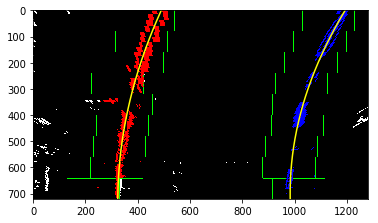

In [11]:
fit, curvature, f = sliding_window(binary_warped,nwindows=9, visualize=True)
left_fit, right_fit = fit[0],fit[1]
left_c, right_c = curvature[0], curvature[1]
print(left_c, right_c)

### Seventh, visualize the 

530.25684635 380.733391068 0.0709754758816


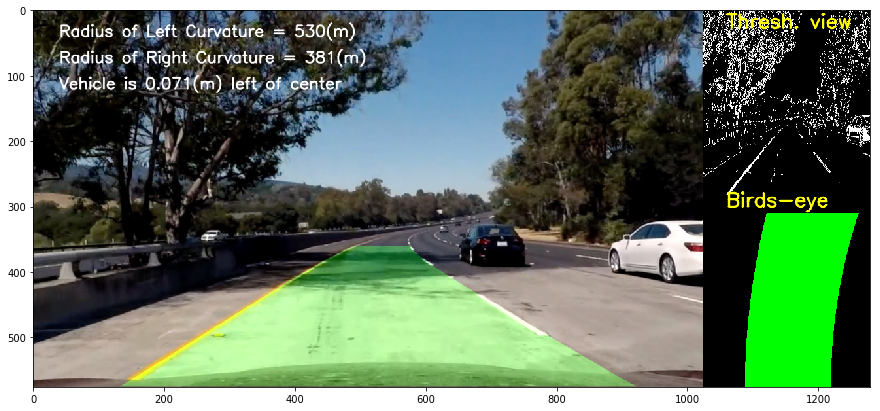

In [12]:
fontFace = cv2.FONT_HERSHEY_SIMPLEX
textsize = 1
fontScale = 1;
thickness = 2;
textOrg1 = (50, 50);
textOrg2 = (50, 100);
textOrg3 = (50, 150);
white = (255,255,255)
def findlanes(warped, undist, Minv):
    
    #plot the final image on the vedio
#     out_img = np.dstack((warped, warped, warped))*255
    
    #find the fitting line through sliding_window
    fit, curvature, _ = sliding_window(warped,nwindows=9, visualize=False)
    left_fit, right_fit = fit[0],fit[1]
#     left_c, right_c = curvature[0], curvature[1]
    
    #find the lane lines on the left and right
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #find the offset
    center_lane = (right_fitx[-1] + left_fitx[-1])/2
    center_image = warped.shape[1]/2
    offset = (center_lane-center_image)*3.7/700

       
    #find lanes on the image
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

   
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    
    offset_dir = 'left'
    if offset < 0:
        offset_dir = 'right'
    text = 'Vehicle is {0:.3f}(m) {1} of center'.format(abs(offset),offset_dir)
    cv2.putText(result,  'Radius of Left Curvature = {:.0f}(m)'.format(curvature[0]), textOrg1, fontFace, fontScale,
        white,thickness, lineType = cv2.LINE_AA);
    cv2.putText(result,  'Radius of Right Curvature = {:.0f}(m)'.format(curvature[1]), textOrg2, fontFace, fontScale,
        white,thickness, lineType = cv2.LINE_AA);
    cv2.putText(result,  text, textOrg3, fontFace, fontScale,
        white,thickness, lineType = cv2.LINE_AA);  
    
    img_out=np.zeros((576,1280,3), dtype=np.uint8)
    img_out[0:576,0:1024,:] =cv2.resize(result,(1024,576))
    warps = np.dstack((combined_binary2, combined_binary2, combined_binary2))
    img_out[0:288,1024:1280, :] =cv2.resize(warps*255,(256,288))
    img_out[310:576,1024:1280,:] =cv2.resize(color_warp,(256,266))
    cv2.putText(img_out,  'Thresh. view', (1060,27), fontFace, fontScale,
        (255,255,0),thickness, lineType = cv2.LINE_AA); 
    cv2.putText(img_out,  'Birds-eye', (1060,300), fontFace, fontScale,
        (255,255,0),thickness, lineType = cv2.LINE_AA);  
    
    return color_warp, img_out, curvature, offset

plt.figure(figsize = (15,10))
colorwarp, res,curvature,offset = findlanes(com_b2, image5, Minv)
plt.imshow(res)
# f,(ax1,ax2) = plt.subplots(1,2,figsize=(20,15))
# ax1.imshow(colorwarp)
# ax1.set_title('visualization in bird view image')
# ax2.imshow(res)
# ax2.set_title('visualization after transformed to world image')
print(curvature[0], curvature[1], offset)

### Eighth, Build a class for tracking lines
In my Line class, I defined line class to track the fitted line coefficients for both left and right lines, the x coordinate of both left lane lines and right lane lines. I defined the method process_image to process each frame of the vedio. The basis idea for processing is below:
1. For each frame, if no previous lane line equation available, I used sliding window method to find the lane line equation; if previous lane line euqation is available, I used the skip_sliding window method to find lane line equation. There two methods are from the lecture nodes. Also, I keep tracking how many missed lane lines, the missed lane lines means detected lane lines is unreasable from my sanity check equation.
2. The sanity check equation check the width of the lane through calculating the distance between pixels on the right lane and pixels on the left lane. I compared it with the value from previous saved distance w, if it is reasable (difference between this one and the old one is acceptable), then I update w with the new frame lane width through average.
3. If sanity check OK, use the current line equation, push back into the collection defined in the line class. Or, use the last valid line equation as the current one.
4. Smoothing the lines, I simply averaged all the line equations saved in the collection, I think is OK. This is will give me a new line equation for both left lanes and right lanes.
5. I used the new lane line equation to generate new X coordinate for both left lane and right lane
6. I recalculate the curvature with the smoothed line equation and calculate the offset of vehicle from road center by comparin the lane center with image center and show them on the images

In [13]:
#This is for drawing only
fontFace = cv2.FONT_HERSHEY_SIMPLEX
textsize = 1
fontScale = 1;
thickness = 2;
textOrg1 = (50, 50);
textOrg2 = (50, 100);
textOrg3 = (50, 150);
white = (255,255,255)

class Line(object):
    
    def __init__(self, mtx, dist, n = 10):
        self.mtx = mtx
        self.dist =dist
        self.n = n
        self.missing = 0
        # was the line detected in the last iteration?
        self.left_fit = []
        self.right_fit = []
        self.left_x = []
        self.right_x = []
        #the width of road from last measurement
        self.width = None
        
        #source points and destination points
        self.src = np.float32([[205,720],[1105,720],[685,450],[595,450]])
        self.dst =  np.float32([[350,720],[950,720],[950,0],[350,0]])
        
    def reset(self):
        self.left_fit = []
        self.right_fit = []
        self.left_x = []
        self.right_x = []
        #the width of road from last measurement
        self.width = None
        
    #to modify the above defined list
    def batch_operation(self, args = None):
        if args is None:
            self.left_fit.pop(0)
            self.right_fit.pop(0)
            self.left_x.pop(0)
            self.right_x.pop(0)
        else:
            self.left_fit.append(args[0])
            self.right_fit.append(args[1])
            self.left_x.append(args[2])
            self.right_x.append(args[3])
            
    def generate_x(self, left_fit, right_fit, ploty):
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        return left_fitx, right_fitx
    
    def smooth(self):
        #here I take the averate of the coefficients instead of the x coordinates of last n frames
        return np.mean(np.array(self.left_fit),axis = 0), np.mean(np.array(self.right_fit),axis=0)
    
    #recalculate the curvature based on the new line equation
    def curvature(self, binary_warped, leftx, rightx, ploty):
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
#         ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
        y_eval = np.max(ploty)
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        return (left_curverad, right_curverad)
    
    def process_image(self, image):
        
        undist = cv2.undistort(image, self.mtx, self.dist)
        im = undist.copy()
        #combined corlor & gradient
        combined_binary = combined(im)
        #transform view to birdr view
        warped = warper(combined_binary,self.src,self.dst)
        
        #find the fitting line through sliding_window, there are two cases, 
        #I assume the first frame is correct or there are too many missing detections
        #I used sliding window, else not using sliding window
        if len(self.left_fit) == 0 or self.missing >= self.n:
            fit, curvature, _ = sliding_window(warped,nwindows=9, visualize=False)
        else:
            fit, curvature = skip_sliding_window(warped, self.left_fit[-1], self.right_fit[-1])
        
        #the deque size is full, then we need to empty one from begging
        if len(self.left_fit) == self.n:
            self.batch_operation()
                
        left_fit, right_fit = fit[0],fit[1]
        
        #generate initial left x point and right x points
        ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
        left_fitx, right_fitx = self.generate_x(left_fit, right_fit, ploty)
        
        #if meets the sanity check, save the result
        if self.sanity_check(left_fitx, right_fitx):
            self.batch_operation([left_fit, right_fit, left_fitx, right_fitx])
            self.missing = 0
        else:
            #if not meets the check, I decided to use the last saved line equation as current line equation
            self.missing = self.missing + 1
            fit, curvature, _ = sliding_window(warped,nwindows=9, visualize=False)
            self.batch_operation([left_fit, right_fit, left_fitx, right_fitx])
#             self.batch_operation([self.left_fit[-1], self.right_fit[-1], self.left_x[-1], self.right_x[-1]])
        #if not meets the result
        
        #apply smoothing and recalculate the x
        left_fit, right_fit = self.smooth()
        left_fitx, right_fitx = self.generate_x(left_fit, right_fit, ploty)
        
        #recalculate the curvature after we find the new lines
        curvature = self.curvature(warped, left_fitx, right_fitx, ploty)
        
        #find the offset
        center_lane = (right_fitx[-1] + left_fitx[-1])/2
        center_image = warped.shape[1]/2
        offset = (center_lane-center_image)*3.7/700
        
        #codes from the lectures to find lanes on the image
        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
#         return result
    #         return result, curvature, offset
    
        #put text on the images    
        offset_dir = 'left'
        if offset < 0:
            offset_dir = 'right'
        text = 'Vehicle is {0:.3f}(m) {1} of center'.format(abs(offset),offset_dir)
        cv2.putText(result,  'Radius of Left Curvature = {:.0f}(m)'.format(curvature[0]), textOrg1, fontFace, fontScale,
            white,thickness, lineType = cv2.LINE_AA);
        cv2.putText(result,  'Radius of Right Curvature = {:.0f}(m)'.format(curvature[1]), textOrg2, fontFace, fontScale,
            white,thickness, lineType = cv2.LINE_AA);
        cv2.putText(result,  text, textOrg3, fontFace, fontScale,
            white,thickness, lineType = cv2.LINE_AA);  

        img_out=np.zeros((576,1280,3), dtype=np.uint8)
        img_out[0:576,0:1024,:] =cv2.resize(result,(1024,576))
        warps = np.dstack((combined_binary, combined_binary, combined_binary))
        img_out[0:288,1024:1280, :] =cv2.resize(warps*255,(256,288))
        img_out[310:576,1024:1280,:] =cv2.resize(color_warp,(256,266))
        cv2.putText(img_out,  'Thresh. view', (1060,27), fontFace, fontScale,
            (255,255,0),thickness, lineType = cv2.LINE_AA); 
        cv2.putText(img_out,  'Birds-eye', (1060,300), fontFace, fontScale,
        (255,255,0),thickness, lineType = cv2.LINE_AA); 
#         self.put_text(result,curvature, offset)
        return img_out;
    
    #sanity _check for the new left_fitx, or right_fitx
    def sanity_check(self,*args):
        left_fitx, right_fitx = args[0],args[1]
        if self.width is not None:
#             diff = np.mean(np.array(right_fitx)-np.array(left_fitx))
#             if abs(diff - self.width) > 100:
#                 return False
#             else:
#                 self.width = (self.width+diff)/2
            for x1, x2, in zip(left_fitx, right_fitx):
                diff = x2-x1
                if abs(diff - self.width) > 50:
#                     print(diff, self.width)
                    return False
        self.width = np.mean(np.array(right_fitx)-np.array(left_fitx))
        return True
#initialize the line class
line  = Line(mtx, dist)

/Users/HJK-BD/.pyenv/versions/3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Users/HJK-BD/.pyenv/versions/3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:58: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Users/HJK-BD/.pyenv/versions/3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:60: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


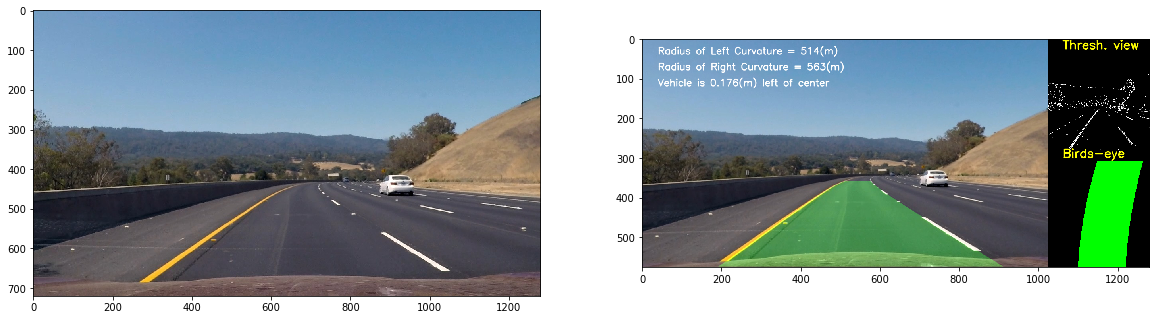

In [14]:
#Test on the test images
image_f = 'test_images/test3.jpg'
image1 = mpimg.imread(image_f)
line.reset()
image2 = line.process_image(image1)
f,(ax1,ax2) = plt.subplots(1,2,figsize=(20,15))
ax1.imshow(image1)
ax2.imshow(image2)

In [15]:
#Test on the vdieos
from moviepy.editor import VideoFileClip
from IPython.display import HTML
line.reset()
test_video = 'project_video.mp4'
output = 'output1.mp4'
clip1 = VideoFileClip(test_video)
white_clip = clip1.fl_image(line.process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output1.mp4
[MoviePy] Writing video output1.mp4


100%|█████████▉| 1260/1261 [03:27<00:00,  6.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output1.mp4 

CPU times: user 3min 17s, sys: 43.6 s, total: 4min 1s
Wall time: 3min 28s


In [21]:
HTML("""
<video width="100%" height="540" controls>
  <source src="{0}">
</video>
""".format(output))